In [63]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

### Importation des bibliothèques ###
import math
import os
import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import functions_analyze as lib
from scipy.signal import find_peaks

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a=None, coeff_rep=None):
    """
    Calcule le champ de forces entre les cellules.
    """
    Rlim = 0.000001
    R = torch.norm(coordinates_diff, dim=2)
    # Empêche la force de répulsion de diverger
    R = torch.where(R > Rlim * torch.ones(1, device=device),
                    R, Rlim * torch.ones(1, device=device)).to(device)
    
    # Force d'adhésion (linéaire)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        -((Fadh / (R0 - Req)) * R - Fadh * Req / (R0 - Req)), torch.zeros_like(R)).to(device)
    
    # Force de répulsion (en 1/R)
    force = torch.where(R <= Req,
                        -Frep * coeff_rep * (1 / Req - 1 / R), force).to(device)
    
    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim=2), axis=1)
    
    return force_field

def plot_environment(cells, camp_field, space_size, path_saving=None, iteration=None):
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    # Traçage de la carte de concentration du cAMP
    extent = [0, space_size, 0, space_size]
    cmap = plt.cm.viridis  # Choisissez une palette de couleurs appropriée
    im = axis.imshow(camp_field.signal.T, origin='lower', extent=extent, cmap=cmap, alpha=0.5)
    plt.colorbar(im, ax=axis, label='Concentration de cAMP')

    # Combine les cellules des deux populations
    all_cells = cells

    # Extrait les coordonnées x et y
    x = [cell.position[0].item() for cell in all_cells]
    y = [cell.position[1].item() for cell in all_cells]

    # Crée une liste de couleurs correspondant à chaque cellule
    colors = ['blue' if cell.pop == 'Population 1' else 'red' for cell in all_cells]

    # Trace toutes les cellules avec les couleurs spécifiées
    axis.scatter(x, y, s=5, color=colors, alpha=0.1, edgecolors='k')

    plt.xlabel('X position (micrometers)')
    plt.ylabel('Y position (micrometers)')
    plt.title(f'Temps: {iteration * DELTA_T:.2f} min')
    # plt.axis('off')  # Vous pouvez commenter cette ligne si vous souhaitez afficher les axes
    plt.savefig(f'{path_saving}image_{iteration}.png',
                bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()


def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):
    b = (Fadh - a * (R0 ** 2 - Req ** 2)) / (R0 - Req)
    c = -Req * (a * Req + (Fadh - a * (R0 ** 2 - Req ** 2)) / (R0 - Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    axis.plot(np.arange(pas, Req, pas), [
              Frep * coeff_rep * (1 / Req - 1 / R) for R in np.arange(pas, Req, pas)], label='Répulsion')
    axis.plot(np.arange(Req, R0, pas), [
              (Fadh / (R0 - Req)) * (R - Req) for R in np.arange(Req, R0, pas)], label='Adhésion')

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()


Device for torch operations: cpu


In [65]:
class CellAgent:
    def __init__(self, id, pop, position, velocity,
                 velocity_magnitude, persistence, space_size,
                 tau, noise, c_params):
        self.id = id  # ID unique de la cellule
        self.pop = pop
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.tau = tau
        self.noise = noise
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)
        # États A et R pour le modèle de FitzHugh-Nagumo
        self.A = torch.tensor(-1.0, device=device)
        self.R = torch.tensor(1.0, device=device)
        self.c_params = c_params  # Paramètres de la cellule pour FitzHugh-Nagumo
        # Paramètres pour la production du cAMP
        self.D = c_params['D']
        self.af = c_params['af']

    def update_state(self, signal_value, dt):
        """
        Met à jour les états A et R de la cellule en fonction du signal cAMP local.
        """
        # Extraction des paramètres
        a = self.c_params['a']
        Kd = self.c_params['Kd']
        gamma = self.c_params['gamma']
        c0 = self.c_params['c0']
        epsilon = self.c_params['epsilon']
        sigma = self.c_params['sigma']
        noise_flag = self.c_params.get('noise', True)

        # Calcul de I_S
        I_S = a * torch.log1p(signal_value / Kd)

        # Mise à jour de A
        dA = (self.A - (self.A ** 3) / 3 - self.R + I_S) * dt
        if noise_flag:
            dA += sigma * math.sqrt(dt) * torch.randn((), device=device)  # Modifié ici
        self.A += dA

        # Mise à jour de R
        dR = (self.A - gamma * self.R + c0) * epsilon * dt
        self.R += dR


In [66]:
class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude,
                 persistence, min_distance, pop_tag, ecart_type,
                 tau, noise, c_params):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.pop_tag = pop_tag  # Identifiant de la population
        self.ecart_type = ecart_type  # Initialisation de l'écart type
        self.tau = tau
        self.noise = noise
        self.c_params = c_params
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        global cell_id_counter  # Utilisez cell_id_counter comme un compteur global
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=self.ecart_type, size=(self.num_cells,), device=device)

        # Logique pour placer les cellules en respectant la distance minimale
        if self.min_distance != 0:
            grid_size = int(np.ceil(self.space_size / self.min_distance))
            grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]
            
            for i, position in enumerate(positions):
                # Logique de placement en respectant la distance minimale
                placed = False
                while not placed:
                    grid_x = int(position[0] / self.min_distance)
                    grid_y = int(position[1] / self.min_distance)
                    conflicts = any(torch.norm(position - other_position) < self.min_distance for other_position in grid[grid_x][grid_y])
                    if not conflicts:
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                nx, ny = grid_x + dx, grid_y + dy
                                if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                    conflicts = any(torch.norm(position - other_position) < self.min_distance for other_position in grid[nx][ny])
                                    if conflicts:
                                        break
                            if conflicts:
                                break
                    if not conflicts:
                        placed = True
                        grid[grid_x][grid_y].append(position)
                        velocity = directions[i] * vitesses_gaussiennes[i]
                        self.cells.append(CellAgent(cell_id_counter, self.pop_tag, position, velocity,
                                                    vitesses_gaussiennes[i], self.persistence, self.space_size,
                                                    self.tau, self.noise, self.c_params))
                        cell_id_counter += 1
                        placed = True  # Assurez-vous que cela est correctement géré dans votre logique
                    else:
                        position = torch.rand(2, device=device) * self.space_size
        else:
            for i, position in enumerate(positions):
                velocity = directions[i] * vitesses_gaussiennes[i]
                self.cells.append(CellAgent(cell_id_counter, self.pop_tag, position, velocity,
                                            vitesses_gaussiennes[i], self.persistence, self.space_size,
                                            self.tau, self.noise, self.c_params))
                cell_id_counter += 1

In [67]:
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

In [68]:
class cAMP:
    def __init__(self, space_size, grid_resolution, D, aPDE):
        """
        Initialise la grille 2D pour le cAMP.
        """
        self.space_size = space_size
        self.grid_resolution = grid_resolution
        self.grid_size = int(space_size / grid_resolution)
        self.D = D
        self.aPDE = aPDE
        self.dx = grid_resolution  # Pour correspondre à la notation du premier code
        self.dt = self.dx ** 2 / (8 * self.D)  # Pas de temps pour la stabilité numérique

        # Grille de concentration du cAMP
        self.signal = torch.zeros((self.grid_size, self.grid_size), device=device)
    
    def compute_laplacian(self, S):
        """
        Calcule le Laplacien du signal S avec des conditions aux limites de Neumann (flux nul).
        """
        laplacian_S = torch.zeros_like(S)
        laplacian_S[1:-1, 1:-1] = (
            S[2:, 1:-1] + S[:-2, 1:-1] + S[1:-1, 2:] + S[1:-1, :-2] - 4 * S[1:-1, 1:-1]
        ) / self.dx ** 2
        return laplacian_S

    def update(self, cells):
        """
        Met à jour la concentration du cAMP en fonction de la production par les cellules, de la diffusion et de la dégradation.
        """
        # Production de cAMP par les cellules
        A_grid = torch.zeros_like(self.signal)
        for cell in cells:
            x_idx = int(cell.position[0].item() / self.grid_resolution)
            y_idx = int(cell.position[1].item() / self.grid_resolution)
            if 0 <= x_idx < self.grid_size and 0 <= y_idx < self.grid_size:
                # La production dépend de l'état d'activation de la cellule (A)
                # On suppose que la production est proportionnelle à Heaviside(A - af)
                af = cell.af  # Seuil d'activation pour la production de cAMP
                if cell.A > af:
                    A_grid[x_idx, y_idx] += cell.D  # D est le taux de production de cAMP par les cellules activées

        # Diffusion et dégradation du cAMP
        laplacian_S = self.compute_laplacian(self.signal)
        self.signal += self.dt * (self.D * laplacian_S - self.aPDE * self.signal + A_grid)
        self.signal = torch.clamp(self.signal, min=0)  # Pour éviter les valeurs négatives

    def get_signal_at_position(self, position):
        """
        Renvoie la concentration du cAMP à une position donnée.
        """
        x_idx = int(position[0].item() / self.grid_resolution)
        y_idx = int(position[1].item() / self.grid_resolution)
        if 0 <= x_idx < self.grid_size and 0 <= y_idx < self.grid_size:
            return self.signal[x_idx, y_idx]
        else:
            return torch.tensor(0.0, device=device)

In [69]:
def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.
    """    
    # Normalise le vecteur d'entrée
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999
    if persistence == 1:
        persistence = 0.9999999
    # Calcule l'angle entre le vecteur d'entrée et l'axe x
    theta = torch.atan2(dX_norm[:, 1], dX_norm[:, 0]).to(device)
    
    # Calcule le changement d'angle basé sur le vecteur d'orientation (n)
    dtheta = torch.arcsin((n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau

    # Génère du bruit aléatoire pour la perturbation de l'angle
    rnd = (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * noise * np.sqrt(dt)
    
    # Mise à jour de l'angle
    theta_update = theta + dtheta + rnd.squeeze(1)

    # Calcule la moyenne pondérée de la nouvelle direction et de l'ancienne direction
    new_dir_x = torch.cos(theta_update)
    new_dir_y = torch.sin(theta_update)
    
    # Crée un nouveau tenseur pour la direction mise à jour
    new_direction = torch.stack((new_dir_x, new_dir_y), dim=1)
    
    return new_direction

def compute_local_gradient(signal_grid, position, grid_resolution):
    """
    Calcule le gradient local du cAMP à la position donnée.
    """
    x_idx = int(position[0].item() / grid_resolution)
    y_idx = int(position[1].item() / grid_resolution)
    grid_size = signal_grid.shape[0]

    # Gestion des bords
    if 1 <= x_idx < grid_size - 1 and 1 <= y_idx < grid_size - 1:
        grad_x = (signal_grid[x_idx + 1, y_idx] - signal_grid[x_idx - 1, y_idx]) / (2 * grid_resolution)
        grad_y = (signal_grid[x_idx, y_idx + 1] - signal_grid[x_idx, y_idx - 1]) / (2 * grid_resolution)
        grad = torch.tensor([grad_x, grad_y], device=device)
    else:
        grad = torch.tensor([0.0, 0.0], device=device)  # Pas de gradient aux bords

    return grad

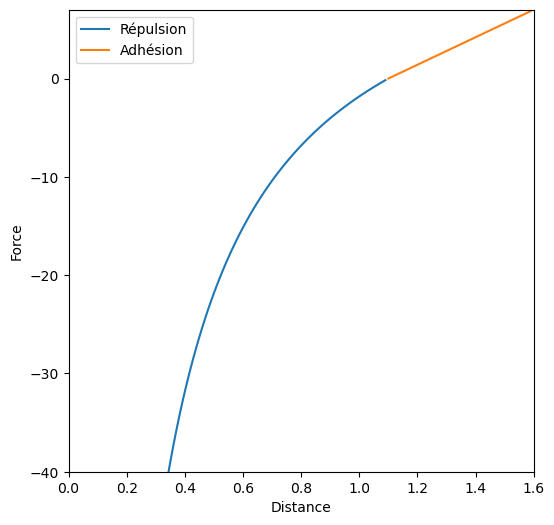

1052 cells


In [70]:
PLOT = True

# In[Simulation parameters]
# Paramètres de l'espace
SPACE_SIZE = 100# 2048  # Micromètres

# Paramètres temporels
TIME_SIMU = 1000  # Temps de simulation en minutes
DELTA_T = 0.01  # Intervalle de simulation en minutes
PLOT_INTERVAL = 100  # Intervalle pour la sauvegarde des images

# Paramètres de simulation
MU = 1  # Mobilité en min·kg⁻¹
F_REP = 40  # Force de répulsion
F_ADH = 7  # Force d'adhésion
R_EQ = 1.1  # Rayon d'équilibre en μm
R_0 = 1.6  # Rayon d'interaction en μm
MIN_DISTANCE_INIT = R_EQ
COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

# Facteur de fluctuation
FLUCTUATION_FACTOR = 3

# Définition des cellules
PACKING_FRACTION =0.1# 0.00005
N_CELLS = int((PACKING_FRACTION * SPACE_SIZE ** 2) /
              (math.pi * ((R_EQ / 2) ** 2)))  # Nombre de cellules
print(N_CELLS, "cells")
# Paramètres de la Population 1
velocity_magnitude_pop1 = 3  # μm/min
ECART_TYPE_POP1 = 0.3
NOISE_POP_1 = 8  # Intensité du bruit sur l'angle à chaque étape
TAU_POP_1 = 5  # Temps caractéristique pour l'alignement
PERSISTENCE_POP1 = 0
# Paramètres de la Population 2
velocity_magnitude_pop2 = 8  # μm/min
ECART_TYPE_POP2 = 0.5
NOISE_POP_2 = 5
TAU_POP_2 = 5
PERSISTENCE_POP2 = 0

# Paramètres des cellules pour le modèle de FitzHugh-Nagumo
cell_params = {
    'c0': 1.0,
    'a': 0.05,
    'gamma': 0.5,
    'Kd': 1e-5,
    'sigma': 0.15,
    'epsilon': 0.2,
    'D': 1000.0,
    'af': 0.0,
    'noise': True
}

In [71]:
# Définition des populations
cell_id_counter = 0  # Commencez le comptage des ID à partir de 0
population1 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                         velocity_magnitude=velocity_magnitude_pop1,
                         persistence=PERSISTENCE_POP1, ecart_type=ECART_TYPE_POP1,
                         min_distance=MIN_DISTANCE_INIT, pop_tag="Population 1",
                         tau=TAU_POP_1, noise=NOISE_POP_1, c_params=cell_params)

population2 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                         velocity_magnitude=velocity_magnitude_pop2,
                         persistence=PERSISTENCE_POP2, ecart_type=ECART_TYPE_POP2,
                         min_distance=MIN_DISTANCE_INIT, pop_tag="Population 2",
                         tau=TAU_POP_2, noise=NOISE_POP_2, c_params=cell_params)

cells = population1.cells + population2.cells

surface = Surface()

# In[Initialisation]

# Initialisation de la grille de cAMP (déplacée avant l'appel à plot_environment)
grid_resolution = 2.0  # Ajustez selon vos besoins
D_cAMP = 5.0  # Coefficient de diffusion du cAMP
aPDE = 10.0  # Taux de dégradation du cAMP
camp_field = cAMP(SPACE_SIZE, grid_resolution, D_cAMP, aPDE)

# Paramètre de chimiotaxie
chemotaxis_sensitivity = 0.1  # À ajuster selon vos besoins

positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])

if PLOT:
    PATH = f'./simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    else:
        print("WARNING : FOLDER DOES ALREADY EXIST!")
        sys.exit(0)
    plot_environment(cells, camp_field, SPACE_SIZE, path_saving=PATH, iteration=0)


In [72]:
# In[Simulation]
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2 * (SPACE_SIZE / 2) ** 2)
# Création du data_list vide pour créer la liste qui deviendra le dataFrame
data_list = []
while time < TIME_SIMU:
    # Mettre à jour les états A et R des cellules
    for cell in cells:
        signal_value = camp_field.get_signal_at_position(cell.position)
        cell.update_state(signal_value, DELTA_T)

    # Mettre à jour la grille de cAMP
    camp_field.update(cells)

    # Calculer le gradient du cAMP pour chaque cellule et ajuster la direction
    for cell in cells:
        grad_cAMP = compute_local_gradient(camp_field.signal, cell.position, camp_field.grid_resolution)
        if torch.norm(grad_cAMP) > 0:
            grad_cAMP = grad_cAMP / torch.norm(grad_cAMP)
            cell.direction = (1 - chemotaxis_sensitivity) * cell.direction + chemotaxis_sensitivity * grad_cAMP
            cell.direction = torch.nn.functional.normalize(cell.direction, p=2, dim=0)

    # Paiwise distance.
    positions = torch.stack([cell.position for cell in cells])
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff - (SPACE_SIZE / 2), SPACE_SIZE) - (SPACE_SIZE / 2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
        print("At least one distance is greater than the max distance.")

    # Calcul du champ de forces
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a=COEFF_CARRE, coeff_rep=COEFF_REP)
    
    # Calcul du déplacement
    V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
    direction = torch.stack([cell.direction for cell in cells])
    fluctuations = (torch.rand(V0.shape, device=V0.device) - 0.5) * FLUCTUATION_FACTOR
    displacement = MU * force_field * DELTA_T + (V0 + fluctuations) * direction * DELTA_T
    positions += displacement

    # Mise à jour des positions des cellules
    for idx, cell in enumerate(cells):
        cell.position += displacement[idx]
        cell.position = torch.remainder(cell.position, SPACE_SIZE)
        # Mise à jour de la direction de la cellule
        new_direction = autovel(displacement[idx].unsqueeze(0), cell.direction.unsqueeze(0),
                                cell.tau, cell.noise, DELTA_T, persistence=cell.persistence)
        cell.direction = new_direction.squeeze(0)

        # Ajouter les informations de la cellule à la liste temporaire
        data_list.append({
            'frame': time,
            'particle': cell.id,
            'pop_tag': cell.pop,
            'x': cell.position[0].item(),
            'y': cell.position[1].item(),
            'dir_x': cell.direction[0].item(),
            'dir_y': cell.direction[1].item()
        })

    # Tracer les résultats
    if PLOT:
        marker_radius = 1.1
        marker_size = (np.pi) * marker_radius ** 2
        if iteration % PLOT_INTERVAL == 0:
            plot_environment(cells, camp_field, SPACE_SIZE, path_saving=PATH, iteration=iteration)



    # Mise à jour du temps
    time += DELTA_T
    iteration += 1

KeyboardInterrupt: 

In [ ]:
# Création du DataFrame à partir de la liste temporaire après la boucle
data_frame = pd.DataFrame(data_list)

# Traitement des données (ajustement des positions, calcul des vitesses, etc.)
def adjust_positions_xy(group, dt, space_size):
    # Calculer les différences pour obtenir 'dx' et 'dy', en prenant en compte la nature toroïdale
    group['dx'] = group['x'].diff().fillna(0)
    group['dy'] = group['y'].diff().fillna(0)

    # Correction pour la nature toroïdale de l'espace
    group['dx'] = np.where(group['dx'] > space_size / 2, group['dx'] - space_size,
                           np.where(group['dx'] < -space_size / 2, group['dx'] + space_size, group['dx']))
    group['dy'] = np.where(group['dy'] > space_size / 2, group['dy'] - space_size,
                           np.where(group['dy'] < -space_size / 2, group['dy'] + space_size, group['dy']))
    
    # Calculer les nouvelles positions ajustées
    group['adjusted_x'] = group['x'].iloc[0] + group['dx'].cumsum()
    group['adjusted_y'] = group['y'].iloc[0] + group['dy'].cumsum()

    # Calculer la distance parcourue à chaque pas de temps
    group['distance'] = np.sqrt(group['dx'] ** 2 + group['dy'] ** 2)

    # Calculer la vitesse pour chaque pas de temps
    group['vitesse'] = group['distance'] / dt

    # Remplacer les colonnes 'x' et 'y' par les valeurs ajustées
    group['x'], group['y'] = group['adjusted_x'], group['adjusted_y']

    # Supprimer les colonnes temporaires inutiles
    group.drop(['adjusted_x', 'adjusted_y', 'dx', 'dy'], axis=1, inplace=True)

    return group

# Fonction pour calculer l'angle en radians entre deux vecteurs de direction successifs
def angle_between_directions(row):
    # Extract direction components
    dx1, dy1 = row['dir_x'], row['dir_y']
    dx2, dy2 = row['dir_x_next'], row['dir_y_next']
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    if angle_change > np.pi:
        angle_change = angle_change - 2 * np.pi
    if angle_change < -np.pi:
        angle_change = angle_change + 2 * np.pi

    return angle_change

# Appliquer la fonction à chaque groupe de particules
df = data_frame.groupby('particle').apply(lambda group: adjust_positions_xy(group, dt=DELTA_T, space_size=SPACE_SIZE)).reset_index(drop=True)

# Assurez-vous que votre DataFrame est trié par particule et par frame
df.sort_values(by=['particle', 'frame'], inplace=True)

# Décaler les directions pour obtenir le vecteur direction au temps t+1 pour chaque particule
df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)

# Appliquer la fonction pour calculer l'angle entre les directions successives
df['angle_change'] = df.apply(angle_between_directions, axis=1)

# Optionnel : Supprimer les lignes où la direction suivante est NaN
df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

# Calculer la vitesse moyenne pour chaque particule
vitesse_moyenne = df.groupby('particle')['vitesse'].mean()

# Tracer les histogrammes
plt.figure(figsize=(10, 6))
plt.hist(df[df['pop_tag'] == 'Population 1']['angle_change'], bins=100, alpha=0.1, color='blue', label='angle_change pop1', density=True)
plt.hist(df[df['pop_tag'] == 'Population 2']['angle_change'], bins=100, alpha=0.1, color='red', label='angle_change pop2', density=True)
plt.legend()
plt.xlim([-np.pi, np.pi])
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme normalisé de angle_change')
plt.show()

# Tracer les histogrammes des vitesses
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(df['vitesse'], bins=100)
axs[0].set_title('Histogramme des vitesses instantanées')
axs[0].set_xlabel('Vitesse [μm/min]')
axs[0].set_ylabel('Nombre de particules')

axs[1].hist(vitesse_moyenne, bins=50)
axs[1].set_title('Histogramme des vitesses moyennes')
axs[1].set_xlabel('Vitesse moyenne [μm/min]')
axs[1].set_ylabel('Nombre de particules')

plt.tight_layout()
plt.show()
